# Implementación de un NMPC en la simulación de un proceso de fermentación alcohólica usando Pyomo 

Partida (2017) llevó a cabo dos fermentaciones por lotes utilizando la levadura Saccharomyces cCerevisiae y azúcares fermentables de sorgo dulce como sustrato, con concentraciones iniciales de 165.88 g/L y 187.8 g/L respectivamente, obteniendo productividades de 2.16 g/L h y 1.83 g/L h, a partir de dicha investigación se determinaron los parámetros cinéticos de un modelo de crecimiento:

$ \mu=0.28\left(\frac{s}{86.56+s}\right)\left(1-\frac{P}{85.7}\right)\left(1-\frac{X}{56.2}\right) $

In [1]:
from pyomo.environ import *
from pyomo.dae import *
import numpy as np
import matplotlib.pyplot as plt
import csv
from itertools import zip_longest

In [5]:
m.t = ContinuousSet(bounds=(0,36)) #time

In [2]:
m = ConcreteModel()

A continuación se muestran un resumen de los valores de los parámetros utilizados para esta sección

In [3]:
m.umax = 0.11   #Máximum growth (1/hr) #Calculated in ParEst.py
m.Ks = 11.36    #Monod constant (g/L) #Calculated in ParEst.py
m.Yxs = 0.023   #Biomass/Substrate yield (dimenssionless) #Simple calculation using experimental data
m.Ypx = 17.67   #Product/Biomass yield(dimensionless) #Simple calculation using experimental data
m.Xcrit = 56.2  #Critical biomass concentration (g/L) #From literature (Rivera,2013)
m.Pcrit = 85.7  #Critical product concentration (g/L) #From literature (Rivera,2013)
m.den = 1050    #Density (kg/m^3) #From literature (Wu, 2015)
m.Cp = 3.67     #Heat capacity of juice (kJ/kg °C) #Simple calculation with Teja's formula (Teja, 1983)
m.Hs = -91.2    #Heat of reaction (kJ/mol) #From literature (Gee, 1988)
m.Tc = 24       #Cooling water temperature (°C)
m.Ts = 30       #Setpoint (°C)
m.Con = 5.5     #Conversion factor
m.Kd = 1.44*10**28  #Pre-exponential factor(kJ/kmol) #From literature (Félix, 2014)
m.Ed = 177700   #Activation energy for cell death (kJ/kmol) #From literature (Phisalaphong, 2006)
m.R = 8.314     #Gas constant (kJ/kmol K)

In [6]:
#Declaring dependent variables
m.S = Var(m.t)  #Substrate (g/L)
m.X = Var(m.t)  #Biomass (g/L)
m.P = Var(m.t)  #Product (g/L)
m.T = Var(m.t)  #Temperature (° C)
m.u = Var(m.t, initialize=0, bounds=(0,1000)) #Cooling rate (kJ/h m^3 °C)

In [7]:
#Declaring derivatives
m.dSdt = DerivativeVar(m.S, wrt=m.t)
m.dXdt = DerivativeVar(m.X, wrt=m.t)
m.dPdt = DerivativeVar(m.P, wrt=m.t)
m.dTdt = DerivativeVar(m.T, wrt=m.t)

Posteriormente se programaron los modelos del proceso para reflejar el comportamiento de temperatura sin control y el efecto de ésta sobre la concentración de biomasa. Las ecuaciones siguientes muestran los balances de materia de biomasa, sustrato y producto propuestos por Shuler y Kargi (2002): 

$ \frac{dX}{dt}=\left(\mu_{max}\frac{S}{S+K_s}\ -\ Ae^{\left(-E_D/RT\right)}\right)\left(1-\frac{X}{X_c}\right)\left(1-\frac{P}{P_c}\right)X $

$ \frac{dS}{dt}=\left(\mu_{max}\frac{S}{S+K_s}\ -\ Ae^{\left(-E_D/RT\right)}\right)\left(1-\frac{X}{X_c}\right)\left(1-\frac{P}{P_c}\right)\frac{X}{Y_{X/S}} $

$ \frac{dP}{dt}=Y_{P/X}\ast\mu_{max}\frac{S}{S+K_s}\left(1-\frac{X}{X_c}\right)\left(1-\frac{P}{P_c}\right)X $

Para la implementación del controlador NMPC, se realizó una modificación al modelo de temperatura, considerando el efecto de la tasa de enfriamiento u como se muestra en la ecuación siguiente (Gee y Ramirez, 1988): 

$ \frac{dT}{dt}=\frac{1}{\rho C_p}∆HSdSdt-u(T-Tc) $

El controlador se trata como un problema de optimización que tendrá como función objetivo la función costo de un controlador NMPC que proponen Puigjaner y Heyen (2007); este se muestra en la ecuación siguiente:

$ J=\sum_{j=1}^{N}\left[T\left(k+j\right)-Ts\left(k+j\right)\right]^2+\sum_{j=1}^{N_U}{\mathrm{\Delta u}\left(\kappa+j-1\right)^2}$

El problema de optimización se encuentra a continuación
$$
min\ J\left[T\left(k\right),u\left(k\right)\right] \\
\frac{dy}{dt}=f\left[y\left(k\right),u\left(k\right)\right] \\
h\left[y\left(k\right),u\left(k\right)\right]=0 \\
g\left[y\left(k\right),u\left(k\right)\right]\geq0 \\
0\le u\le1000 \\
28\le T\le32 \\
$$

In [8]:
def _dX(m, t):

    return m.dXdt[t] == ((m.umax * (m.S[t]/(m.Ks + m.S[t])) * (1-(m.X[t]/m.Xcrit)) * (1-(m.P[t]/m.Pcrit)) - (m.Kd*(exp(-1*m.Ed/(m.R*(m.T[t]+273)))))) * m.X[t]) 

m.dX = Constraint(m.t, rule=_dX)

#Biomass initial concentration
def _icX(X):
    
    return m.X[0] == 0.74

m.icX = Constraint(rule=_icX)

def _dS(m, t):

    return m.dSdt[t] == -1/m.Yxs * ((m.umax * (m.S[t]/(m.Ks + m.S[t])) * (1-(m.X[t]/m.Xcrit)) * (1-(m.P[t]/m.Pcrit))) * m.X[t])

m.dS = Constraint(m.t, rule=_dS)

#Substrate initial concentration
def _icS(S):
    
    return m.S[0] == 165.88

m.icS = Constraint(rule=_icS)

def _dP(m, t):

    return m.dPdt[t] == m.Ypx * ((m.umax * (m.S[t]/(m.Ks + m.S[t])) * (1-(m.X[t]/m.Xcrit)) * (1-(m.P[t]/m.Pcrit))) * m.X[t]) 

m.dP = Constraint(m.t, rule=_dP)

#Product initial concentration    
def _icP(P):

    return m.P[0] == 0

m.icP = Constraint(rule=_icP)

def _dT(m, t):
    
    return m.dTdt[t] == (1/(m.Cp*m.den))*(m.Hs*m.Con*((-1/m.Yxs * ((m.umax * (m.S[t]/(m.Ks + m.S[t])) * (1-(m.X[t]/m.Xcrit)) * (1-(m.P[t]/m.Pcrit)) - (m.Kd*(exp(-1*m.Ed/(m.R*(m.T[t]+273)))))) * m.X[t])))-(m.u[t]*(m.T[t]-m.Tc)))
            
m.dT = Constraint(m.t, rule=_dT)

#Initial temperature
def _icT (T):
    
    return m.T[0] == 23

m.icT = Constraint(rule=_icT)  

#Upper limit
def _Tu(m, t):
    
    return m.T[t] <= 32

m.Tu = Constraint(m.t, rule=_Tu)

#Lower limit
def _Tl(m, t):
    
    return m.T[t] >= 23
    
m.Tl = Constraint(m.t, rule=_Tl)

#Objective function
m.obj = Objective(
    expr = sum((m.T[t] - m.Ts)**2 for t in m.t),
    sense = minimize)   

In [9]:
#Choosing discretization scheme
disc = TransformationFactory('dae.collocation')

#Discretizing the model; piecewise profile
disc.apply_to(m, nfe=36, ncp=2)
disc.reduce_collocation_points(m, var=m.u, ncp=1, contset=m.t)

In [10]:
#Choosing solver; solving the model
SolverFactory('ipopt').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 766
  Number of variables: 657
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.33905816078186035
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


In [11]:
#Extracting values
t = list(m.t)
T = [value(m.T[t]) for t in m.t]
u = [value(m.u[t]) for t in m.t]
X = [value(m.X[t]) for t in m.t]
P = [value(m.P[t]) for t in m.t]
S = [value(m.S[t]) for t in m.t]

In [12]:
%matplotlib inline

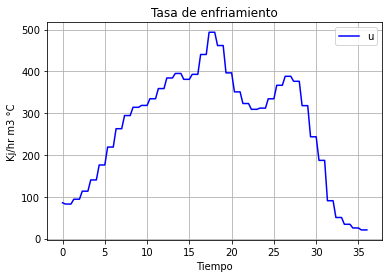

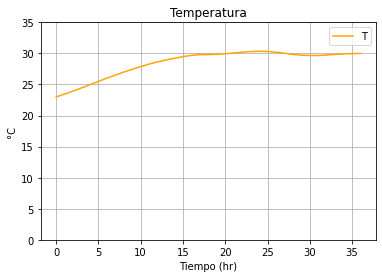

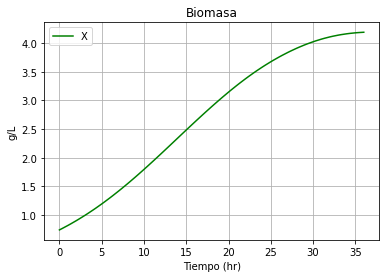

In [13]:
#Plotting cooling rate
plt.figure('Tasa de enfriamiento')
plt.title('Tasa de enfriamiento')
plt.plot(t, u, 'b-', label='u')
plt.xlabel('Tiempo')
plt.ylabel('u (Kj/hr m3 °C)')
plt.legend()
plt.grid()
plt.show()

#Plotting temperature
plt.figure('Temperatura')
plt.title('Temperatura')
plt.plot(t, T, 'orange', label='T')
plt.legend()
plt.ylabel('T (°C)')
plt.ylim([0, 35])
plt.xlabel('Tiempo (hr)')
plt.grid()
plt.show()

#Plotting biomass
plt.figure('Biomasa')
plt.title('Biomasa')
plt.plot(t, X, 'g',label='X')
plt.legend()
plt.ylabel('Biomasa (g/L)')
plt.xlabel('Tiempo (hr)')
plt.grid()
plt.show()